In [0]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c quora-insincere-questions-classification --force

 86% 47.0M/54.4M [00:00<00:00, 59.2MB/s]
100% 54.4M/54.4M [00:00<00:00, 137MB/s] 
100% 5.95G/5.96G [01:12<00:00, 77.3MB/s]
100% 5.96G/5.96G [01:12<00:00, 88.3MB/s]
100% 4.08M/4.08M [00:00<00:00, 15.3MB/s]

 57% 9.00M/15.7M [00:00<00:00, 12.0MB/s]
100% 15.7M/15.7M [00:00<00:00, 17.0MB/s]


In [0]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from wordcloud import STOPWORDS
import pickle

from tqdm import tqdm
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,  Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers


Using TensorFlow backend.


In [0]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [0]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [0]:
from sklearn.utils import class_weight
c_weight = class_weight.compute_class_weight('balanced',np.unique(df_train['target']),df_train['target'])
weight_dict = dict(zip(np.unique(df_train['target']), c_weight))


In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(df_train['question_text'],df_train['target'], test_size = 0.1)

In [0]:
X_train = X_train.fillna("_na_").values
X_val = X_val.fillna("_na_").values

In [0]:
embedding_size = 300 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)



In [0]:
# https://www.kaggle.com/snlpnkj/bidirectional-lstm-keras

inp = Input(shape=(X_train.shape[1],))
x = Embedding(max_features, embedding_size)(inp)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="relu")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100, 256)          330240    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 100, 128)          123648    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
__________

In [0]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(1175509, 100) (1175509,)
(130613, 100) (130613,)


In [0]:
model_log = model.fit(X_train, Y_train,batch_size = 2048, epochs = 5, verbose = 1,validation_data=(X_val, Y_val) )

Train on 1175509 samples, validate on 130613 samples
Epoch 1/5
1175509/1175509 [==============================] - 370s 315us/step - loss: 0.1400 - acc: 0.9467 - val_loss: 0.1195 - val_acc: 0.9522
Epoch 2/5
1175509/1175509 [==============================] - 364s 310us/step - loss: 0.1284 - acc: 0.9474 - val_loss: 0.1154 - val_acc: 0.9515
Epoch 3/5
1175509/1175509 [==============================] - 360s 306us/step - loss: 0.1177 - acc: 0.9507 - val_loss: 0.1138 - val_acc: 0.9551
Epoch 4/5
1175509/1175509 [==============================] - 361s 307us/step - loss: 0.1153 - acc: 0.9524 - val_loss: 0.1157 - val_acc: 0.9518
Epoch 5/5
1175509/1175509 [==============================] - 361s 307us/step - loss: 0.1181 - acc: 0.9524 - val_loss: 0.1206 - val_acc: 0.9552


In [0]:
pred_y = model.predict([X_val], batch_size=2048, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_val, (pred_y>thresh).astype(int))))

130613/130613 [==============================] - 13s 103us/step
F1 score at threshold 0.1 is 0.5319477709959051
F1 score at threshold 0.11 is 0.5391572212787805
F1 score at threshold 0.12 is 0.5453886427708418
F1 score at threshold 0.13 is 0.5509994664039732
F1 score at threshold 0.14 is 0.5569493226292023
F1 score at threshold 0.15 is 0.5618188010899182
F1 score at threshold 0.16 is 0.5665135627004073
F1 score at threshold 0.17 is 0.5716554888810449
F1 score at threshold 0.18 is 0.5773603559070688
F1 score at threshold 0.19 is 0.5825375793850232
F1 score at threshold 0.2 is 0.5873015873015872
F1 score at threshold 0.21 is 0.5926835024781685
F1 score at threshold 0.22 is 0.5964054636951833
F1 score at threshold 0.23 is 0.6004571762073828
F1 score at threshold 0.24 is 0.603386149365714
F1 score at threshold 0.25 is 0.6061942467675655
F1 score at threshold 0.26 is 0.6075575473619882
F1 score at threshold 0.27 is 0.6110162916989914
F1 score at threshold 0.28 is 0.6133557505385383
F1 score

In [0]:
pred_y = (pred_y>0.37).astype(int)

Accuracy on validation without embedding: 95.157%
Precision on validation without embedding: 0.594
Recall on validation without embedding: 0.643
F1-Score on validation without embedding: 0.618


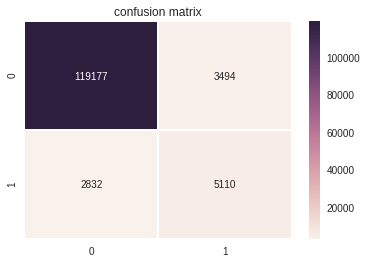

In [0]:
print("Accuracy on validation without embedding: %0.3f%%"%(accuracy_score(Y_val, pred_y)*100))
print("Precision on validation without embedding: %0.3f"%(precision_score(Y_val, pred_y)))
print("Recall on validation without embedding: %0.3f"%(recall_score(Y_val, pred_y)))
print("F1-Score on validation without embedding: %0.3f"%(f1_score(Y_val, pred_y)))
confusion_matrix_l1 = confusion_matrix(Y_val,pred_y)
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(confusion_matrix_l1,annot=True,fmt="d",linewidths=.5)
plt.title("confusion matrix")
plt.show()

In [0]:
del model

In [0]:
import time
del model, inp, x
import gc; gc.collect()
time.sleep(10)

In [0]:
!unzip embeddings.zip


Archive:  embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  


In [0]:

!cd glove.840B.300d/
!ls

/bin/bash: line 0: cd: glove.840B.300d/: No such file or directory
embeddings.zip	sample_data		   test.csv	 train.csv
kaggle.json	sample_submission.csv.zip  test.csv.zip  train.csv.zip


In [0]:
EMBEDDING_FILE = 'glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embedding_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [0]:
# removing unnecessary variable to get space in RAM 
import time
del all_embs,embeddings_index
time.sleep(5)

In [0]:
# https://www.kaggle.com/snlpnkj/bidirectional-lstm-keras
inp = Input(shape=(X_train.shape[1],))
x = Embedding(max_features, embedding_size,weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="relu")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 100, 256)          330240    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 100, 128)          123648    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
__________

In [0]:
model_log = model.fit(X_train, Y_train,batch_size = 2048, epochs = 5, verbose = 1,validation_data=(X_val, Y_val) )

Train on 1175509 samples, validate on 130613 samples
Epoch 1/5
1175509/1175509 [==============================] - 349s 297us/step - loss: 0.9933 - acc: 0.9353 - val_loss: 0.9801 - val_acc: 0.9392
Epoch 2/5
1175509/1175509 [==============================] - 359s 305us/step - loss: 0.2215 - acc: 0.9451 - val_loss: 0.1150 - val_acc: 0.9536
Epoch 3/5
1175509/1175509 [==============================] - 357s 304us/step - loss: 0.1257 - acc: 0.9494 - val_loss: 0.1124 - val_acc: 0.9559
Epoch 4/5
1175509/1175509 [==============================] - 354s 301us/step - loss: 0.1178 - acc: 0.9509 - val_loss: 0.1111 - val_acc: 0.9570
Epoch 5/5
1175509/1175509 [==============================] - 354s 301us/step - loss: 0.1115 - acc: 0.9526 - val_loss: 0.1100 - val_acc: 0.9581


In [0]:
#del model 

In [0]:
pred_y = model.predict([X_val], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_val, (pred_y>thresh).astype(int))))

130613/130613 [==============================] - 15s 112us/step
F1 score at threshold 0.1 is 0.5477975632614808
F1 score at threshold 0.11 is 0.5551391436089625
F1 score at threshold 0.12 is 0.5633631194151097
F1 score at threshold 0.13 is 0.5709558671464616
F1 score at threshold 0.14 is 0.5774167753882413
F1 score at threshold 0.15 is 0.5838541220785892
F1 score at threshold 0.16 is 0.5895103373231774
F1 score at threshold 0.17 is 0.5947117085249382
F1 score at threshold 0.18 is 0.6003958258366319
F1 score at threshold 0.19 is 0.6047447090551722
F1 score at threshold 0.2 is 0.6091879350348027
F1 score at threshold 0.21 is 0.6120989745037162
F1 score at threshold 0.22 is 0.6169144714825262
F1 score at threshold 0.23 is 0.6212047725288583
F1 score at threshold 0.24 is 0.6247782377291543
F1 score at threshold 0.25 is 0.6286371362863714
F1 score at threshold 0.26 is 0.630595878591006
F1 score at threshold 0.27 is 0.6335787468465222
F1 score at threshold 0.28 is 0.6348094316934176
F1 score

In [0]:
pred_y = (pred_y>0.34).astype(int)

Accuracy on validation with glove embedding: 95.297%
Precision on validation with glove embedding: 0.594
Recall on validation with glove embedding: 0.714
F1-Score on validation with glove embedding: 0.649


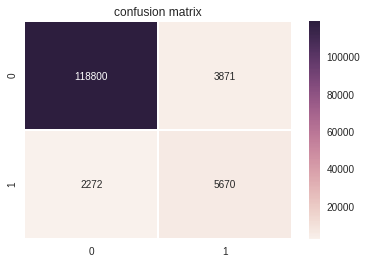

In [0]:
print("Accuracy on validation with glove embedding: %0.3f%%"%(accuracy_score(Y_val, pred_y)*100))
print("Precision on validation with glove embedding: %0.3f"%(precision_score(Y_val, pred_y)))
print("Recall on validation with glove embedding: %0.3f"%(recall_score(Y_val, pred_y)))
print("F1-Score on validation with glove embedding: %0.3f"%(f1_score(Y_val, pred_y)))
confusion_matrix_l1 = confusion_matrix(Y_val,pred_y)
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(confusion_matrix_l1,annot=True,fmt="d",linewidths=.5)
plt.title("confusion matrix")
plt.show()